In [ ]:
#====================================================================== INSTALL PRE-REQS ==================================================================
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem #Hell of an import
import pandas as pd #Importing panda as "pd"
from rdkit.Chem import AllChem
from rdkit.Chem import Draw #Import function to draw molecules
from itertools import chain
from rdkit.Chem import rdMolDescriptors
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem #Hell of an import
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.externals import joblib
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/RxnFun.py
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/QsarHelperFun.py
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/SimAD.py
runfile('/content/RxnFun.py')
runfile('/content/QsarHelperFun.py')
runfile('/content/SimAD.py')

Epoch 1/500
5/5 [==============================] - 1s 133ms/step - loss: 11.1480 - accuracy: 0.0000e+00 - val_loss: 2.2496 - val_accuracy: 0.0000e+00
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 1.8994 - accuracy: 0.0077 - val_loss: 1.8557 - val_accuracy: 0.0000e+00
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 1.4613 - accuracy: 0.0077 - val_loss: 0.9337 - val_accuracy: 0.0000e+00
Epoch 4/500
5/5 [==============================] - 0s 13ms/step - loss: 1.1833 - accuracy: 0.0051 - val_loss: 1.0460 - val_accuracy: 0.0000e+00
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 1.0010 - accuracy: 0.0129 - val_loss: 1.4291 - val_accuracy: 0.0000e+00
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 0.9962 - accuracy: 0.0021 - val_loss: 1.2216 - val_accuracy: 0.0000e+00
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 0.8205 - accuracy: 0.0051 - val_loss: 1.4770 - val_accurac

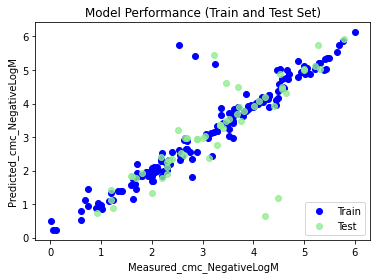

%Error (Test): 16.348 %
%Error (Train): -0.816 %
%Error (Total): 24.984 %

MAE (Test): 23.928 %
MAE (Train): 8.451 %
MAE (Total): 33.471 %

RMS (Test): 0.7831
RMS (Train): 0.418
RMS (Total): 0.5337


In [3]:
#_______________ Upload Data __________________
NonIonicSurfs = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/NonIonicSurfsLit_git_version.csv')#Upload Data  
FingerPrintType = 'Fingerprinter.FingerprintMol'
DescriptorList = ['Descriptors.MolWt','Descriptors.TPSA','Descriptors.NOCount','Descriptors.NumHAcceptors','Descriptors.NumHDonors','Descriptors.NHOHCount','Descriptors.NumValenceElectrons','Descriptors.NumRotatableBonds','Descriptors.MolLogP','Descriptors.MolMR','Chem.Fragments.fr_C_O','Chem.Fragments.fr_ester','Chem.Fragments.fr_ether','Chem.Fragments.fr_NH1','Chem.Fragments.fr_NH2','Chem.Fragments.fr_unbrch_alkane','Chem.Fragments.fr_amide']
NonIonicSurfs_Descr = CalcDescr_SMIdf(NonIonicSurfs, FingerPrintType, DescriptorList)

#_______________ Build QSPR model to predict CMC of non-ionic surfactants (NI-surfs)_______________
Descriptors_train,  Descriptors_test,  Property_train,  Property_test = PreProcess_SMIdf(NonIonicSurfs_Descr,property_id = 'cmc_NegativeLogM',TestSize = 0.2)
Seq_cmc_1 = Sequential([Dense(units = 5, input_dim = Descriptors_train.shape[1], activation='relu'),Dense(units= 10 ,  activation='relu' ),Dense(units= 1 ,  activation='linear' )]) # Output layer
Seq_cmc_1.compile(optimizer = SGD( lr=0.01,momentum=0.9,nesterov=True),loss= 'mean_squared_error',metrics = ['accuracy']) 
mod_hist = Seq_cmc_1.fit(Descriptors_train,Property_train,validation_split = 0.1,batch_size=32,epochs=500) 
NonIonicSurfs_mod_performance = Seq_Model_performance(NonIonicSurfs_Descr, property_id = 'cmc_NegativeLogM', model = Seq_cmc_1)

In [4]:
#_______________Generate NI-surf candidates using cheap bio-based feedstock & green chemistry_______________
#----- DATA UPLOAD  
Biomass_precursors = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/Surfactant_Precursors.csv') #Using Panda function to read the dataset
Biomass_precursor_mols = [Chem.MolFromSmiles(SMILE) for SMILE in Biomass_precursors.smiles]
Nucleophilic_Reactants = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/Nucleophilic_Reactants.csv') 
N = [Chem.MolFromSmiles(SMILE) for SMILE in Nucleophilic_Reactants.smiles] # N = Nucleophiles
Electrophilic_reactants = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/Electrophilic_reactants.csv')
E_total = [Chem.MolFromSmiles(SMILE) for SMILE in Electrophilic_reactants.smiles]
print("___Biomass_precursors:___\nA dataset containing algae-derived molecules that can be extracted in lab. The three functional groups being modified in this set include alcohols/alkenes (phytols) and esters (FAMEs).\n\n___Nucleophilic Reactants (N):___\nThis dataset contains alcohol and amine reactants meant to attack various electrophilic groups on the Biomass_precursors set.\n\n___Electrophilic Reactants (E_total):___\nThis set provides readily available/synthesizable epoxides and cyclic carbonates that can be opened up by nucleophilic groups\non the biomass precursors. One epoxide and one cyclic carbonate have hydroxyl functionality, allowing them to be added to the precursors via transesterification\nbefore being attacked.")
#----- Splitting data by functional group
fam = FG_split(Biomass_precursor_mols, Chem.MolFromSmarts('[#6]-[#6](-[#8])=O'), keep_group = True) # FAME precursors ('fam')
phy = FG_split(Biomass_precursor_mols, Chem.MolFromSmarts('[OH]'), keep_group = True) # Phytol precursors ('phy')
E_OH = FG_split(E_total, Chem.MolFromSmarts('[OH]'), keep_group = True)# Electrophilic reactants WITH Nucleophilic OH group ('E_OH')
E = FG_split(E_total, Chem.MolFromSmarts('[OH]'), keep_group = False) # Electrophilic reactants W/OUT Nucleophilic OH group ('E')
#----- Phytol RXN Pathway 1 
phy_1 = Epoxidation(phy) #____(phy ---> phy_1)
phy_1_a = Nuc_ring_opening(phy_1, N, return_format= 'Mol') #____(phy_1 ---> phy_1_a)
phy_1_a_i = Nuc_ring_opening(E, NHOH_limit(phy_1_a, 3), return_format= 'Mol') #____(phy_1_a ---> phy_1_a_i)
phy_1_a_ii = Nuc_ring_opening(E,   NHOH_limit(phy_1_a_i, 3)   , return_format= 'Mol') #____(phy_1_a_i ---> phy_1_a_ii)
phy_1_b  = Nuc_ring_opening(phy_1, E_OH, return_format= 'Mol') # #____(phy_1 ---> phy_1_b)
phy_1_b_i = Nuc_ring_opening(phy_1_b,    N,       return_format = 'Mol')#____(phy_1_b ---> phy_1_b_i)
phy_1_b_ii = Nuc_ring_opening(E,    NHOH_limit(phy_1_b_i, 4),       return_format = 'Mol')
phy_1_c = Cyclic_Carbonation(phy_1) #____(phy_1 ---> phy_1_c)
phy_1_c_i = Nuc_ring_opening(phy_1_c, N, return_format= 'Mol') #____(phy_1_c ---> phy_1_c_i)
#phy_1_c_ii = Nuc_ring_opening(phy_1_c, phy, return_format= 'Mol') #____(phy_1_c ---> phy_1_c_ii)
#----- Phytol RXN Pathway 2 
phy_2 = Nuc_ring_opening( E_total,  phy, return_format = 'Mol')#____(phy ---> phy_2)
phy_2_a = Nuc_ring_opening( phy_2,  N, return_format = 'Mol')#____(phy_2 ---> phy_2_a)
#phy_2_b = Nuc_ring_opening( phy_2, phy, return_format = 'Mol')#____(phy_2 ---> phy_2_b)
#___________________ COMBINING Unique Products from Phytol RXN Pathway 1&2 (phy_1 & phy_2) ___________________
all_phy_products_list = [x for l in [phy_1_a,phy_1_a_i,phy_1_a_ii,phy_1_b,phy_1_b_i, phy_2,phy_2_a] for x in l] #,phy_1_b_ii #phy_1_a_ii, phy_2_b phy_1_c_ii
all_phy_products_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_products_list] #Mol to Smiles
all_phy_products_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_phy_products_smiles)] #Smiles to unique Mol
all_phy_products_smiles_unique = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_products_unique] #Unique Mol to unique Smiles
#_____________________________________________________________________________________________________________
#----- FAME RXN Pathway 1 
fam_1 = fame_transesterifications(fam, N, return_format= 'Mol') #____(fam ---> fam_1)
fam_1_a = Nuc_ring_opening(E_total, NHOH_limit(fam_1, 4), return_format= 'Mol') #____(phy_1 ---> phy_1_a)
#----- FAME RXN Pathway 2 
fam_2  = fame_transesterifications(fam, E_OH, return_format= 'Mol') #____(fam ---> fam_2)
fam_2_a = Nuc_ring_opening(fam_2,  N, return_format = 'Mol')#____(fam_2 ---> fam_2_a)
fam_2_a_i = Nuc_ring_opening(E_total,  NHOH_limit(fam_2_a, 3 ), return_format = 'Mol')
fam_2_b  = fame_transesterifications(fam, NHOH_limit(fam_2,3), return_format= 'Mol') #____(fam ---> fam_2)
#___________________ COMBINING all fam_1 & fam_2 products ____________________________________________________
all_fam_list = [x for l in [fam_1, fam_1_a, fam_2_a] for x in l] #
all_fam_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_fam_list] #Mol to Smiles
all_fam_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_fam_smiles)] #Smiles to unique Mol
all_fam_smiles_unique = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_fam_unique] #Unique Mol to unique Smiles
#_____________________________________________________________________________________________________________
#___________________ COMBINING ALL RXN PATH PRODUCTS (FAME + Phytols) ________________________________________
all_phy_fam_smiles_list = [x for l in [all_fam_smiles_unique, all_phy_products_smiles_unique ] for x in l]
all_phy_fam_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_phy_fam_smiles_list)] #Smiles to unique Mol
generated_phytolFAME_surfs = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_fam_unique] #Unique Mol to unique Smiles
#_____________________________________________________________________________________________________________
GenPHY_SMIdf = pd.DataFrame({'smiles': all_phy_products_smiles_unique})
GenFAM_SMIdf = pd.DataFrame({'smiles': all_fam_smiles_unique})
print('\n\nUnique Phytol products:',len(all_phy_products_smiles_unique))
print('Unique FAME products:',len(all_fam_smiles_unique))
print('Total unique products:',len(generated_phytolFAME_surfs))
GenMols_SMIdf = pd.DataFrame({'smiles': generated_phytolFAME_surfs}) # Turn generated smiles into dataframe
GenMols_SMIdf.head()

___Biomass_precursors:___
A dataset containing algae-derived molecules that can be extracted in lab. The three functional groups being modified in this set include alcohols/alkenes (phytols) and esters (FAMEs).

___Nucleophilic Reactants (N):___
This dataset contains alcohol and amine reactants meant to attack various electrophilic groups on the Biomass_precursors set.

___Electrophilic Reactants (E_total):___
This set provides readily available/synthesizable epoxides and cyclic carbonates that can be opened up by nucleophilic groups
on the biomass precursors. One epoxide and one cyclic carbonate have hydroxyl functionality, allowing them to be added to the precursors via transesterification
before being attacked.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:38] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for at

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:38] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 39 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 39 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:38] Explicit valence for atom # 39 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 39 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 39 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for a

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:38] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:38] Explicit valence for at

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization

RDKit ERROR: [08:40:39] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:39] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 31 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 31 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 31 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 31 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 31 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 31 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence fo

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:39] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:39] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:39] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 40 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for atom # 38 O, 3, is greater than permitted
RDKit ERROR: [08:40:39] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:40] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:40] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 37 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence fo

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:40] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 34 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:40] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:40] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:41] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 22 O, 3, is greater than permitted


One or more epoxide_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:41] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:41] Explicit valence for atom 

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removi

RDKit ERROR: [08:40:42] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 33 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:42] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:44] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom 

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:44] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:44] Explicit valence for

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for 

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:45] Explicit valence for atom # 28 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 28 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 28 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 28 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 28 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization

RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:45] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:46] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:46] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:46] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 18 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [08:40:46] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:47] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 3 O, 3, is greater than permitted


One or more transesterification products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:47] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:47] Explicit valence for

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:48] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for 

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:48] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:48] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:48] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:48] Explicit valence for

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:48] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for 

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitiza

RDKit ERROR: [08:40:49] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for 

One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more epoxide_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:49] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:49] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:49] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 32 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for atom # 32 O, 3, is greater than permitted
RDKit ERROR: [08:40:49] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 26 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:50] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 29 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:50] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:50] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:50] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 25 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for 

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:51] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:51] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 30 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:51] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for

One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.
One or more CC5_opening products failed sanitization, removing empty mols.


RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [08:40:51] Explicit valence fo

One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.
One or more transesterification products failed sanitization, removing empty mols.


Unique Phytol products: 3490
Unique FAME products: 2920
Total unique products: 6410


,smiles
0,CCCCCCCCCC(=O)OCC(O)C(O)C(O)COC(=O)OC1COC(C2CO...
1,CC(C)CCCC(C)CCCC(C)CCCC(C)(OCCN)C(CO)OC(=O)OC1...
2,C/C(=C\COC(=O)OC1COC(C(O)COC(=O)OCC(O)C(O)CO)C...
3,CC(C)CCCC(C)CCCC(C)CCCC(C)(O)C(CO)OC(C(O)CN)C(...
4,CC(C)(OCCNC(=O)OC1COC(C2COC(=O)O2)C1O)C(O)COC(...


In [5]:
FingerPrintType = 'Fingerprinter.FingerprintMol'
DescriptorList = ['Descriptors.MolWt','Descriptors.TPSA','Descriptors.NOCount','Descriptors.NumHAcceptors','Descriptors.NumHDonors','Descriptors.NHOHCount','Descriptors.NumValenceElectrons','Descriptors.NumRotatableBonds','Descriptors.MolLogP','Descriptors.MolMR','Chem.Fragments.fr_C_O','Chem.Fragments.fr_ester','Chem.Fragments.fr_ether','Chem.Fragments.fr_NH1','Chem.Fragments.fr_NH2','Chem.Fragments.fr_unbrch_alkane','Chem.Fragments.fr_amide']
#----Calc same descriptors used in model for newly generated and filtered molecules
GenMols_SMIdf_Descr = CalcDescr_SMIdf(GenMols_SMIdf, FingerPrintType, DescriptorList )
#----- Predict property for newly generated molecules
GenMols_FamPhy = ModelPredict_SMIdf(GenMols_SMIdf_Descr,  property_id = 'cmc_NegativeLogM',  model =  Seq_cmc_1)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:281: UserWarning: max_samples (6410) is greater than the total number of samples (223). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


# Gen Mols Within AD: 216
# Gen Mol Outside AD: 6194


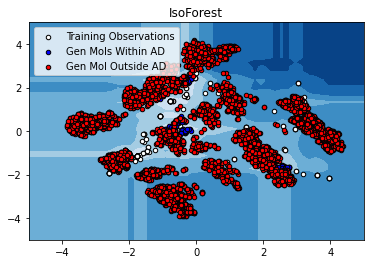

In [6]:
GenMols = IsoForest_OutlierEstimator(GenMols = GenMols_FamPhy,
                           TrainMols = NonIonicSurfs_mod_performance,
                           MaxSamples = len(GenMols_FamPhy))

GenMols_IF = GenMols[GenMols['GenMols_AD'] == 1]

In [7]:
#Mol distance to model (training set)
import statistics
DistSum_T, allTrainMols_T, TrainDistances = FP_Similarity_Filter(GenMols = NonIonicSurfs_mod_performance ,
                                                                 TrainMols = NonIonicSurfs_mod_performance,  
                                                                 RangeTrain2Compare = range(0,(len(NonIonicSurfs_mod_performance)-1)) )

AvgDistTrainSet = TrainDistances.merge(NonIonicSurfs_mod_performance, left_on = 'smiles', right_on = 'smiles')
TrainDist = pd.DataFrame({'smiles': AvgDistTrainSet.smiles,'Pred_CMC':AvgDistTrainSet.Predicted_cmc_NegativeLogM,'Obs_CMC':AvgDistTrainSet.Measured_cmc_NegativeLogM,'Perc_Err':AvgDistTrainSet.Percent_Error,'Abs_Err':[abs(val) for val in AvgDistTrainSet.Percent_Error],'Dist':AvgDistTrainSet.Dist,'Mol':AvgDistTrainSet.Mol_x})
print('Dist Range (Entire set):',round(TrainDist.Dist.min(),4), '-',round(TrainDist.Dist.max(),4))
print('Dist Median (Entire set):' , round(TrainDist.Dist.median(),4), '\nDist Mean (Entire set):' , round(TrainDist.Dist.mean(),4))
print('Dist StDev (Entire set):' ,round(statistics.pstdev(TrainDist.Dist),4))
print('\nMAE(Entire set):',round(TrainDist.Abs_Err.mean(),2),'%')
print('MAE(Dist > med):', round(TrainDist.Abs_Err[TrainDist.Dist >= TrainDist.Dist.median() ].mean(),3),'%')
print('MAE(Dist < med):', round(TrainDist.Abs_Err[TrainDist.Dist < TrainDist.Dist.median() ].mean(),3),'%')
#TrainDist

Dist Range (Entire set): 0.1062 - 0.3949
Dist Median (Entire set): 0.324 
Dist Mean (Entire set): 0.2914
Dist StDev (Entire set): 0.0823

MAE(Entire set): 33.47 %
MAE(Dist > med): 7.92 %
MAE(Dist < med): 59.252 %


In [8]:
Distsummary, allTrainingMols, GenMols_IF_Dist = FP_Similarity_Filter(GenMols = GenMols_IF, 
                                                                    TrainMols = NonIonicSurfs_mod_performance, 
                                                                    RangeTrain2Compare = range(0, len(NonIonicSurfs_mod_performance))  )

GenMols_IF_Dist =  GenMols_IF_Dist.loc[GenMols_IF_Dist["Dist"] >= TrainDist.Dist.median()]

In [9]:
GenMols_IF_Distance  = pd.DataFrame({'smiles': GenMols_IF_Dist.smiles,
                                     'Pred_CMC':GenMols_IF_Dist.Predicted_cmc_NegativeLogM_x,
                                     'Dist':GenMols_IF_Dist.Dist,
                                     'IF_AD':GenMols_IF_Dist.GenMols_AD_x,
                                     'Mol':GenMols_IF_Dist.Mol})
GenMols_IF_Distance

,smiles,Pred_CMC,Dist,IF_AD,Mol
17,CC(=O)OCC(O)C1OCC(OCC(C)O)C1O,0.162168,0.338391,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b5cdb4e0>
18,CC(=O)OCC(O)C1OCC(OCCO)C1O,0.199111,0.338205,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b4c48b70>
24,CC(=O)OCC(OCC(C)O)C1OCC(O)C1O,0.162168,0.335241,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b8632170>
215,CCCCCCCCCCCC(=O)OC1COC(C(O)COCCO)C1O,4.724963,0.335234,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b7bc2bc0>
198,CCCCCCCC(=O)OC1COC(C(O)COCCO)C1O,2.391746,0.335234,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b5d43490>
208,CCCCCCCCCC(=O)OC1COC(C(O)COCCO)C1O,3.532570,0.335234,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b4c2bb20>
212,CCCCCCCCCCCC(=O)OC(COC(C)CO)C1OCC(O)C1O,4.579802,0.335160,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b4c8f030>
195,CCCCCCCC(=O)OC(COC(C)CO)C1OCC(O)C1O,2.227524,0.335160,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b3e0be90>
205,CCCCCCCCCC(=O)OC(COC(C)CO)C1OCC(O)C1O,3.426259,0.335160,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b4c02170>
25,CC(=O)OCC(OCCO)C1OCC(O)C1O,0.199111,0.335031,1.0,<rdkit.Chem.rdchem.Mol object at 0x7fb1b4c133f0>


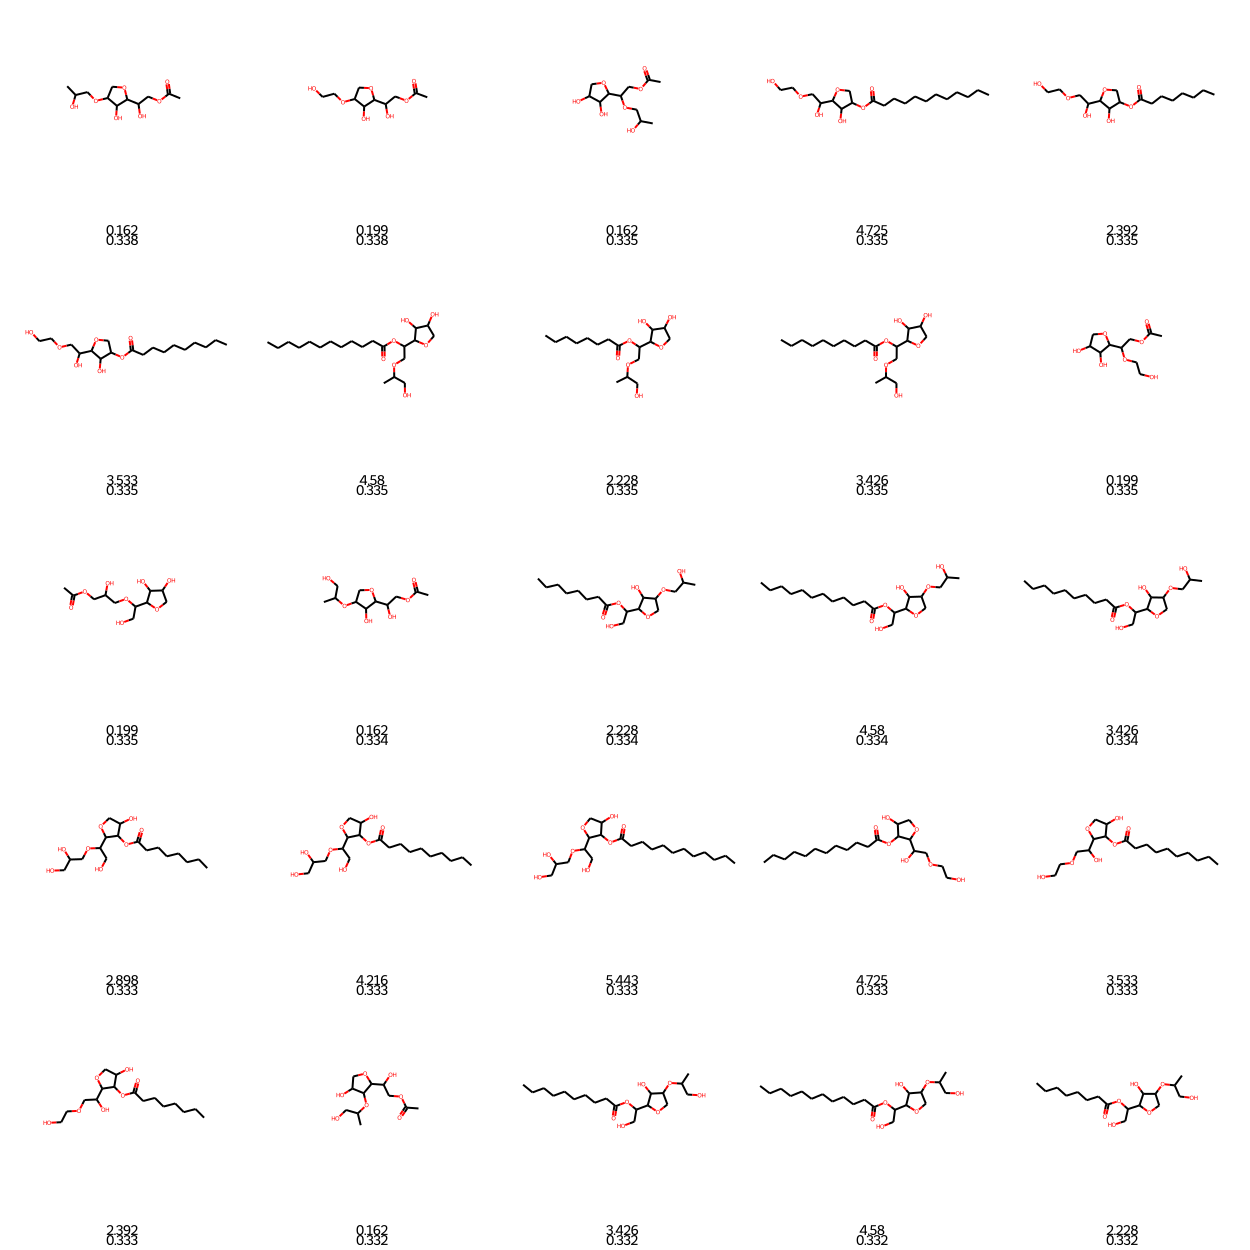

In [10]:
GenMols_IF_Dist_sorted = GenMols_IF_Distance.sort_values(by = 'Dist', ascending = False)
GenMols_IF_Dist_sorted['Pred_CMC_str'] = [str(round(val,3)) for val in GenMols_IF_Dist_sorted.Pred_CMC]
GenMols_IF_Dist_sorted['Dist_str'] = [str(round(val,3)) for val in GenMols_IF_Dist_sorted.Dist]

GenMols_IF_Dist_sorted['PredCMC_Dist'] = GenMols_IF_Dist_sorted[['Pred_CMC_str', 'Dist_str']].agg('\n'.join, axis=1)


Draw.MolsToGridImage(GenMols_IF_Dist_sorted.Mol.head(n=25),
                    molsPerRow = 5, subImgSize = (250,250), 
                    legends = [str(val) for val in GenMols_IF_Dist_sorted.PredCMC_Dist.head(n=25)])

In [11]:
"""
========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================


========================================================== E  N  D ==========================================================
"""

'\n========================================================== E  N  D ==========================================================\n\n\n========================================================== E  N  D ==========================================================\n\n\n========================================================== E  N  D ==========================================================\n\n\n========================================================== E  N  D ==========================================================\n\n\n========================================================== E  N  D ==========================================================\n\n\n========================================================== E  N  D ==========================================================\n\n\n========================================================== E  N  D ==========================================================\n\n\n========================================================== E  N  D =============